In [1]:
from medpy.io import load
import os
import itk
import skimage
import SimpleITK as sitk
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Lambda
from keras.layers import Input, Maximum, concatenate, Activation, Conv3D, MaxPooling3D, Conv2DTranspose
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

'''
from keras import layers
from keras.layers import Input, Conv2D, Maximum, MaxPooling2D, concatenate, Activation, Conv3D, MaxPooling3D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam'''

from keras import backend as K

Using TensorFlow backend.


In [2]:
data_path = '../patients/'
IMG_H = 64
IMG_W = 64

In [3]:
train_ids = next(os.walk(data_path))[1]
train_ids.sort()
train_ids

['CengJia',
 'GangZu',
 'JiaHuiQiong',
 'KongDan',
 'LanDingKun',
 'LiangChengJun',
 'LiuGuangQiong',
 'LiuQuanXing',
 'LiuYanMu',
 'ShenXin',
 'TanHongJun',
 'XiaGang',
 'XiaoChangLun',
 'YangChuanFu',
 'YangXia',
 'YangYunFei',
 'ZhangJianMing',
 'ZhouDaoMing',
 'ZhouLiangYong']

In [4]:
ind_prof = next(os.walk(data_path + '/' + train_ids[0]))[2]
ind_prof

['bak_CengJiaT1SegRAIROIResampling.mha',
 'CengJiaT1RAIROIResamplingNormalize.mha',
 'CengJiaT1SegDistanceMap.mha',
 'CengJiaT1SegRAIROIResampling.mha']

In [5]:
next(file_name for file_name in ind_prof if 'Seg' not in file_name)
#ind_prof

'CengJiaT1RAIROIResamplingNormalize.mha'

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['imshow', 'load', 'resize', 'imread', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy


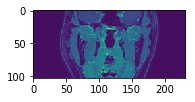

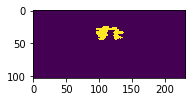

In [6]:
img_name = next(file_name for file_name in ind_prof if 'Seg' not in file_name)
msk_b = next(file_name for file_name in ind_prof if 'bak_' in file_name)
img = sitk.ReadImage(data_path + train_ids[0] + '/' + img_name)
msk = sitk.ReadImage(data_path + train_ids[0] + '/' + msk_b)
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

%pylab inline
subplot(121)
imgplot = plt.imshow(np.flip(np.flip(img_array[:,136,:]), 1))
plt.show()
subplot(122)
plt.imshow(np.flip(np.flip(msk_array[:,136,:]), 1))
plt.show()

In [9]:
#Trying to break the data and then concate to a 1.2w*64*64 data set.

train_z = np.ndarray((103 * len(train_ids), IMG_H, IMG_W, 1), dtype=np.uint8)
train_y = np.ndarray((320 * len(train_ids), IMG_H, IMG_W, 1), dtype=np.uint8)
train_x = np.ndarray((232 * len(train_ids), IMG_H, IMG_W, 1), dtype=np.uint8)
mask_z = np.ndarray((103 * len(train_ids), IMG_H, IMG_W, 1), dtype=np.uint8)
mask_y = np.ndarray((320 * len(train_ids), IMG_H, IMG_W, 1), dtype=np.uint8)
mask_x = np.ndarray((232 * len(train_ids), IMG_H, IMG_W, 1), dtype=np.uint8)
for i in range(len(train_ids)):
    ind_prof = next(os.walk(data_path + '/' + train_ids[i]))[2]
    img_name = next(file_name for file_name in ind_prof if 'Seg' not in file_name)
    msk_b = next(file_name for file_name in ind_prof if 'bak_' in file_name)
    img = sitk.ReadImage(data_path + train_ids[i] + '/' + img_name)
    msk = sitk.ReadImage(data_path + train_ids[i] + '/' + msk_b)
    img_array = sitk.GetArrayFromImage(img)
    msk_array = sitk.GetArrayFromImage(msk)
    
    #z = np.ndarray((103, IMG_H, IMG_W, 1), dtype=np.uint8)
    #y = np.ndarray((320, IMG_H, IMG_W, 1), dtype=np.uint8)
    #x = np.ndarray((232, IMG_H, IMG_W, 1), dtype=np.uint8)
    for z in range(img_array.shape[0]):
        train_z[z + i*103,:,:,0] = resize(img_array[z,:,:], (IMG_H, IMG_W), mode='constant', preserve_range=True)
    for y in range(img_array.shape[1]):
        train_y[y + i*320,:,:,0] = np.flip(np.flip(resize(img_array[:,y,:], (IMG_H, IMG_W),
                                            mode='constant', preserve_range=True), 1))
    for x in range(img_array.shape[2]):
        train_x[x + i*232,:,:,0] = np.flip(np.flip(resize(img_array[:,:,x], (IMG_H, IMG_W),
                                            mode='constant', preserve_range=True), 1))
    
    #z_msk = np.ndarray((103, IMG_H, IMG_W, 1), dtype=np.uint8)
    #y_msk = np.ndarray((320, IMG_H, IMG_W, 1), dtype=np.uint8)
    #x_msk = np.ndarray((232, IMG_H, IMG_W, 1), dtype=np.uint8)
    for z in range(msk_array.shape[0]):
        mask_z[z + i*103,:,:,0] = resize(msk_array[z,:,:], (IMG_H, IMG_W), mode='constant', preserve_range=True)
    for y in range(msk_array.shape[1]):
        mask_y[y + i*320,:,:,0] = np.flip(np.flip(resize(msk_array[:,y,:], (IMG_H, IMG_W),
                                                mode='constant', preserve_range=True), 1))
    for x in range(msk_array.shape[2]):
        mask_x[x + i*232,:,:,0] = np.flip(np.flip(resize(msk_array[:,:,x], (IMG_H, IMG_W),
                                                mode='constant', preserve_range=True), 1))



Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.


In [10]:
tmp1 = np.concatenate((train_x, train_y, train_z), axis=0)
tmp2 = np.concatenate((mask_x, mask_y, mask_z), axis=0)
tmp2.shape

(12445, 64, 64, 1)

(19, 103, 320, 232, 1) (19, 103, 320, 232, 1)


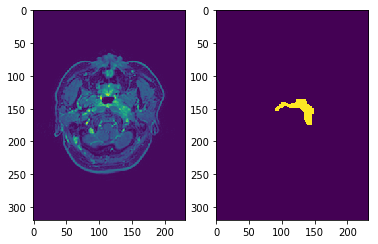

In [7]:
#Trying to directly obtrain data with shape of (# of patients)*original
#size of the image.

X_data = np.ndarray((len(train_ids), img_array.shape[0], img_array.shape[1], img_array.shape[2], 1), dtype=np.uint8)
Y_mask = np.ndarray((len(train_ids), msk_array.shape[0], msk_array.shape[1], msk_array.shape[2], 1), dtype=np.uint8)
for i in range(len(train_ids)):
    ind_prof = next(os.walk(data_path + '/' + train_ids[i]))[2]
    img_name = next(file_name for file_name in ind_prof if 'Seg' not in file_name)
    msk_b = next(file_name for file_name in ind_prof if 'bak_' in file_name)
    img = sitk.ReadImage(data_path + train_ids[i] + '/' + img_name)
    msk = sitk.ReadImage(data_path + train_ids[i] + '/' + msk_b)
    img_array = sitk.GetArrayFromImage(img)
    msk_array = sitk.GetArrayFromImage(msk)
    for z in range(img_array.shape[0]):
        X_data[i,z,:,:,0] = img_array[z,:,:]
    for y in range(img_array.shape[1]):
        X_data[i,:,y,:,0] = img_array[:,y,:]
    for x in range(img_array.shape[0]):
        X_data[i,:,:,x,0] = img_array[:,:,x]
        
    for z in range(msk_array.shape[0]):
        Y_mask[i,z,:,:,0] = msk_array[z,:,:]
    for y in range(msk_array.shape[1]):
        Y_mask[i,:,y,:,0] = msk_array[:,y,:]
    for x in range(msk_array.shape[0]):
        Y_mask[i,:,:,x,0] = msk_array[:,:,x]
        

subplot(121)
imshow(X_data[18,51,:,:,0])
subplot(122)
imshow(Y_mask[18,51,:,:,0])
print(X_data.shape, Y_mask.shape)

In [72]:
#preprocess the input, due to err:"expected input_3 to have
#shape (65, 65, 65, 1) but got array with shape (103, 320, 232, 1)"
def preprocessing(arch_name):
    #X_global = []
    #X_local = []
    #Y = []
    
    if arch_name == 'input':
        s = 65
        X2 = np.ndarray((s, s, s, 1), dtype=np.uint8)
        X1 = np.ndarray((33, 33, 33, 1), dtype=np.uint8)
        Y = np.ndarray((s, s, s, 1), dtype=np.uint8)
        for i in range(1):
            print(str(i+1)+'/19 data processed')
            for z in range(0, X_data.shape[1]-s, 5):
                for y in range(0, X_data.shape[2]-s, 25):
                    for x in range(0, X_data.shape[3]-s, 20):
                        if X_data[i,z+16:z+49,y+16:y+49,x+16:x+49,0].any() != 0:
                            print(X2[:,:,:,0].shape)
                            print(X_data[i,z:z+s,y:y+s,x:x+s,0].shape)
                            break
                            X2[:,:,:,0] = np.concatenate((X2[:,:,:,0], X_data[i,z:z+s,y:y+s,x:x+s,0]))
                            X1[:,:,:,0] = np.concatenate((X1[:,:,:,0], X_data[i,z+16:z+49,y+16:y+49,x+16:x+49,0]))
                            Y[:,:,:,0] = np.concatenate((Y[:,:,:,0], Y_mask[i,z:z+s,y:y+s,x:x+s,0]))
    
    #X1 = np.asarray(X_global)
    #X2 = np.asarray(X_local)
    #Y_out = np.asarray(Y)
    
    return [X1, X2, Y]    
            

In [73]:
f_data = preprocessing('input')

1/19 data processed
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 65, 65)
(65, 

In [11]:
a = ndarray((1, 65,65,1))
b = ndarray((65,65,1))
c = np.concatenate((a,b))
c.shape

ValueError: all the input arrays must have same number of dimensions

In [36]:
def two_path3D(X_input, arch_type):
    if arch_type == 'input':
        #upper path
        X = Conv3D(64, (7, 7, 7), strides=(1,1,1), padding='valid')(X_input)
        X1 = Conv3D(64, (7, 7, 7), strides=(1,1,1), padding='valid')(X_input)
        X1 = Maximum()([X,X1])
        X1 = MaxPooling3D((4,4,4), strides=(1,1,1), padding='valid')(X1)
        
        X = Conv3D(64, (3,3,3), strides=(1,1,1), padding='valid')(X1)
        X1 = Conv3D(64, (3,3,3), strides=(1,1,1), padding='valid')(X1)
        X1 = Maximum()([X,X1])
        X1 = MaxPooling3D((2,2,2), strides=(1,1,1), padding='valid')(X1)
        
        #lower path
        X = Conv3D(160, (13, 13, 13), strides=(1,1,1), padding='valid')(X_input)
        X2 = Conv3D(160, (13, 13, 13), strides=(1,1,1), padding='valid')(X_input)
        X2 = Maximum()([X,X2])
        
        #concatenation
        X = concatenate([X1,X2], axis=4)
        X = Conv3D(5, (21, 21, 21), strides=(1,1,1), padding='valid')(X)
        #X = Activation('softmax')(X)
    
        #model = Model(inputs=X_input, outputs=X)
        return X
def InputCascadeCNN(shape1, shape2):
    #concatenate input and output of the 1st two path network
    X1 = Input(shape1)
    X = two_path3D(X1, 'input')
    
    X2 = Input(shape2)
    X = concatenate([X, X2], axis=4)
    X = two_path3D(X, 'input')
    X = Activation('softmax')(X)
    
    model = Model(inputs=[X1,X2], outputs=X)
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics = ['accuracy'])
    return model

In [15]:
m1 = InputCascadeCNN((65,65,65,1), (33,33,33,1))
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 65, 65, 65, 1 0                                            
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 59, 59, 59, 6 22016       input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_8 (Conv3D)               (None, 59, 59, 59, 6 22016       input_2[0][0]                    
__________________________________________________________________________________________________
maximum_4 (Maximum)             (None, 59, 59, 59, 6 0           conv3d_7[0][0]                   
                                                                 conv3d_8[0][0]                   
__________

In [18]:
X_data[0,0:64,0:64,0:64,0].shape

(64, 64, 64)

In [16]:
print('-'*30)
print('Creating and compiling model...')
print('-'*30)
m1 = InputCascadeCNN((65,65,65,1), (33,33,33,1))
#m1 = get_unet()
print(m1.summary())
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

print('-'*30)
print('Fitting model...')
print('-'*30)
m1.fit([f_data[1],f_data[0]], f_data[2], batch_size=8, epochs=50, verbose=1, shuffle=True,
        validation_split=0.2,
        callbacks=[model_checkpoint])

------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 65, 65, 65, 1 0                                            
__________________________________________________________________________________________________
conv3d_21 (Conv3D)              (None, 59, 59, 59, 6 22016       input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_22 (Conv3D)              (None, 59, 59, 59, 6 22016       input_4[0][0]                    
__________________________________________________________________________________________________
maximum_10 (Maximum)            (None, 59, 59, 59, 6 0           conv3d_21[0][0]                  
               

ValueError: Error when checking input: expected input_4 to have 5 dimensions, but got array with shape (29640, 33, 33, 33)

In [14]:
np.save('../Processed_Data/img_z', oz)
np.save('../Processed_Data/img_y', oy)
np.save('../Processed_Data/img_x', ox)
np.save('../Processed_Data/msk_z', oz_msk)
np.save('../Processed_Data/msk_y', oy_msk)
np.save('../Processed_Data/msk_x', ox_msk)

In [20]:
train_z = np.ndarray((len(oz), IMG_H, IMG_W, 1), dtype=np.uint8)
train_y = np.ndarray((len(oy), IMG_H, IMG_W, 1), dtype=np.uint8)
train_x = np.ndarray((len(ox), IMG_H, IMG_W, 1), dtype=np.uint8)
train_z_m = np.ndarray((len(oz_msk), IMG_H, IMG_W, 1), dtype=np.uint8)
train_y_m = np.ndarray((len(oy_msk), IMG_H, IMG_W, 1), dtype=np.uint8)
train_x_m = np.ndarray((len(ox_msk), IMG_H, IMG_W, 1), dtype=np.uint8)

In [21]:
for n, img in enumerate(oz):
    train_z[n] = resize(img, (IMG_H, IMG_W, 1), mode='constant', preserve_range=True)
for n, img in enumerate(oy):
    train_y[n] = resize(img, (IMG_H, IMG_W, 1), mode='constant', preserve_range=True)
for n, img in enumerate(ox):
    train_x[n] = resize(img, (IMG_H, IMG_W, 1), mode='constant', preserve_range=True)
for n, img in enumerate(oz_msk):
    train_z_m[n] = resize(img, (IMG_H, IMG_W, 1), mode='constant', preserve_range=True)
for n, img in enumerate(oy_msk):
    train_y_m[n] = resize(img, (IMG_H, IMG_W, 1), mode='constant', preserve_range=True)
for n, img in enumerate(ox_msk):
    train_x_m[n] = resize(img, (IMG_H, IMG_W, 1), mode='constant', preserve_range=True)

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.


In [23]:
train_z.shape

(103, 128, 128, 1)

In [43]:
print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()
print(model.summary())
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

print('-'*30)
print('Fitting model...')
print('-'*30)
model.fit(train_z, train_z_m, batch_size=32, epochs=3000, verbose=1, shuffle=True,
          validation_split=0.1,
          callbacks=[model_checkpoint])

------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 32) 320         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_58[0][0]                  
_______________

Epoch 5/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0100 - dice_coef: 0.0100 - val_loss: -1.1099e-05 - val_dice_coef: 1.1099e-05
Epoch 6/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0100 - dice_coef: 0.0100 - val_loss: -1.1098e-05 - val_dice_coef: 1.1098e-05
Epoch 7/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0100 - dice_coef: 0.0100 - val_loss: -1.1096e-05 - val_dice_coef: 1.1096e-05
Epoch 8/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0100 - dice_coef: 0.0100 - val_loss: -1.1094e-05 - val_dice_coef: 1.1094e-05
Epoch 9/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0100 - dice_coef: 0.0100 - val_loss: -1.1092e-05 - val_dice_coef: 1.1092e-05
Epoch 10/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0100 - dice_coef: 0.0100 - val_loss: -1.1091e-05 - val_dice_coef: 1.1091e-05
Epoch 11/3000
92/92 [==============================] - 1s 6ms/step - loss: 

Epoch 58/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0103 - dice_coef: 0.0103 - val_loss: -1.1082e-05 - val_dice_coef: 1.1082e-05
Epoch 59/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0103 - dice_coef: 0.0103 - val_loss: -1.1083e-05 - val_dice_coef: 1.1083e-05
Epoch 60/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0103 - dice_coef: 0.0103 - val_loss: -1.1083e-05 - val_dice_coef: 1.1083e-05
Epoch 61/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0103 - dice_coef: 0.0103 - val_loss: -1.1084e-05 - val_dice_coef: 1.1084e-05
Epoch 62/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0104 - dice_coef: 0.0104 - val_loss: -1.1085e-05 - val_dice_coef: 1.1085e-05
Epoch 63/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0104 - dice_coef: 0.0104 - val_loss: -1.1086e-05 - val_dice_coef: 1.1086e-05
Epoch 64/3000
92/92 [==============================] - 1s 6ms/step - l

Epoch 111/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0124 - dice_coef: 0.0124 - val_loss: -1.1224e-05 - val_dice_coef: 1.1224e-05
Epoch 112/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0125 - dice_coef: 0.0125 - val_loss: -1.1242e-05 - val_dice_coef: 1.1242e-05
Epoch 113/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0128 - dice_coef: 0.0128 - val_loss: -1.1271e-05 - val_dice_coef: 1.1271e-05
Epoch 114/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0130 - dice_coef: 0.0130 - val_loss: -1.1302e-05 - val_dice_coef: 1.1302e-05
Epoch 115/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0133 - dice_coef: 0.0133 - val_loss: -1.1336e-05 - val_dice_coef: 1.1336e-05
Epoch 116/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.0136 - dice_coef: 0.0136 - val_loss: -1.1398e-05 - val_dice_coef: 1.1398e-05
Epoch 117/3000
92/92 [==============================] - 1s 6ms/s

92/92 [==============================] - 1s 6ms/step - loss: -0.7029 - dice_coef: 0.7029 - val_loss: -0.0038 - val_dice_coef: 0.0038
Epoch 220/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.6974 - dice_coef: 0.6974 - val_loss: -0.0762 - val_dice_coef: 0.0762
Epoch 221/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.6840 - dice_coef: 0.6840 - val_loss: -0.0042 - val_dice_coef: 0.0042
Epoch 222/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7095 - dice_coef: 0.7095 - val_loss: -0.0456 - val_dice_coef: 0.0456
Epoch 223/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.6927 - dice_coef: 0.6927 - val_loss: -0.0048 - val_dice_coef: 0.0048
Epoch 224/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.6993 - dice_coef: 0.6993 - val_loss: -0.0125 - val_dice_coef: 0.0125
Epoch 225/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7147 - dice_coef: 0.7147 - val_loss: -0.0098 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.7891 - dice_coef: 0.7891 - val_loss: -0.0997 - val_dice_coef: 0.0997
Epoch 330/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7906 - dice_coef: 0.7906 - val_loss: -0.0891 - val_dice_coef: 0.0891
Epoch 331/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7898 - dice_coef: 0.7898 - val_loss: -0.0921 - val_dice_coef: 0.0921
Epoch 332/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7898 - dice_coef: 0.7898 - val_loss: -0.0405 - val_dice_coef: 0.0405
Epoch 333/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7855 - dice_coef: 0.7855 - val_loss: -0.0510 - val_dice_coef: 0.0510
Epoch 334/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7910 - dice_coef: 0.7910 - val_loss: -0.1837 - val_dice_coef: 0.1837
Epoch 335/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7908 - dice_coef: 0.7908 - val_loss: -0.0455 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8177 - dice_coef: 0.8177 - val_loss: -0.1014 - val_dice_coef: 0.1014
Epoch 440/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8152 - dice_coef: 0.8152 - val_loss: -0.2299 - val_dice_coef: 0.2299
Epoch 441/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8126 - dice_coef: 0.8126 - val_loss: -0.1904 - val_dice_coef: 0.1904
Epoch 442/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8164 - dice_coef: 0.8164 - val_loss: -0.0625 - val_dice_coef: 0.0625
Epoch 443/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8149 - dice_coef: 0.8149 - val_loss: -0.1399 - val_dice_coef: 0.1399
Epoch 444/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8148 - dice_coef: 0.8148 - val_loss: -0.1434 - val_dice_coef: 0.1434
Epoch 445/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8116 - dice_coef: 0.8116 - val_loss: -0.3043 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8308 - dice_coef: 0.8308 - val_loss: -0.3569 - val_dice_coef: 0.3569
Epoch 550/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8291 - dice_coef: 0.8291 - val_loss: -0.2589 - val_dice_coef: 0.2589
Epoch 551/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8312 - dice_coef: 0.8312 - val_loss: -0.4501 - val_dice_coef: 0.4501
Epoch 552/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8288 - dice_coef: 0.8288 - val_loss: -0.2028 - val_dice_coef: 0.2028
Epoch 553/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8296 - dice_coef: 0.8296 - val_loss: -0.0799 - val_dice_coef: 0.0799
Epoch 554/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8302 - dice_coef: 0.8302 - val_loss: -0.5327 - val_dice_coef: 0.5327
Epoch 555/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8187 - dice_coef: 0.8187 - val_loss: -0.6675 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8225 - dice_coef: 0.8225 - val_loss: -0.0544 - val_dice_coef: 0.0544
Epoch 660/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8261 - dice_coef: 0.8261 - val_loss: -0.6444 - val_dice_coef: 0.6444
Epoch 661/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8272 - dice_coef: 0.8272 - val_loss: -0.7144 - val_dice_coef: 0.7144
Epoch 662/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8157 - dice_coef: 0.8157 - val_loss: -0.0158 - val_dice_coef: 0.0158
Epoch 663/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.7752 - dice_coef: 0.7752 - val_loss: -0.2079 - val_dice_coef: 0.2079
Epoch 664/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8077 - dice_coef: 0.8077 - val_loss: -0.6270 - val_dice_coef: 0.6270
Epoch 665/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8258 - dice_coef: 0.8258 - val_loss: -0.1171 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8529 - dice_coef: 0.8529 - val_loss: -0.7763 - val_dice_coef: 0.7763
Epoch 770/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8509 - dice_coef: 0.8509 - val_loss: -0.8231 - val_dice_coef: 0.8231
Epoch 771/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8507 - dice_coef: 0.8507 - val_loss: -0.7932 - val_dice_coef: 0.7932
Epoch 772/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8523 - dice_coef: 0.8523 - val_loss: -0.3768 - val_dice_coef: 0.3768
Epoch 773/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8512 - dice_coef: 0.8512 - val_loss: -0.4115 - val_dice_coef: 0.4115
Epoch 774/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8511 - dice_coef: 0.8511 - val_loss: -0.5884 - val_dice_coef: 0.5884
Epoch 775/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8531 - dice_coef: 0.8531 - val_loss: -0.6688 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8474 - dice_coef: 0.8474 - val_loss: -0.5987 - val_dice_coef: 0.5987
Epoch 880/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8575 - dice_coef: 0.8575 - val_loss: -0.9798 - val_dice_coef: 0.9798
Epoch 881/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8491 - dice_coef: 0.8491 - val_loss: -0.7415 - val_dice_coef: 0.7415
Epoch 882/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8557 - dice_coef: 0.8557 - val_loss: -0.3103 - val_dice_coef: 0.3103
Epoch 883/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8591 - dice_coef: 0.8591 - val_loss: -0.9463 - val_dice_coef: 0.9463
Epoch 884/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8585 - dice_coef: 0.8585 - val_loss: -0.8067 - val_dice_coef: 0.8067
Epoch 885/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8585 - dice_coef: 0.8585 - val_loss: -0.6874 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8655 - dice_coef: 0.8655 - val_loss: -0.8006 - val_dice_coef: 0.8006
Epoch 990/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8630 - dice_coef: 0.8630 - val_loss: -0.7084 - val_dice_coef: 0.7084
Epoch 991/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8664 - dice_coef: 0.8664 - val_loss: -0.8947 - val_dice_coef: 0.8947
Epoch 992/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8650 - dice_coef: 0.8650 - val_loss: -0.9819 - val_dice_coef: 0.9819
Epoch 993/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8613 - dice_coef: 0.8613 - val_loss: -0.8766 - val_dice_coef: 0.8766
Epoch 994/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8642 - dice_coef: 0.8642 - val_loss: -0.5579 - val_dice_coef: 0.5579
Epoch 995/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8679 - dice_coef: 0.8679 - val_loss: -0.9604 - v

92/92 [==============================] - 1s 6ms/step - loss: -0.8662 - dice_coef: 0.8662 - val_loss: -0.9647 - val_dice_coef: 0.9647
Epoch 1100/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8693 - dice_coef: 0.8693 - val_loss: -0.9751 - val_dice_coef: 0.9751
Epoch 1101/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8683 - dice_coef: 0.8683 - val_loss: -0.8918 - val_dice_coef: 0.8918
Epoch 1102/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8741 - dice_coef: 0.8741 - val_loss: -0.9223 - val_dice_coef: 0.9223
Epoch 1103/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8725 - dice_coef: 0.8725 - val_loss: -0.9033 - val_dice_coef: 0.9033
Epoch 1104/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8710 - dice_coef: 0.8710 - val_loss: -0.9560 - val_dice_coef: 0.9560
Epoch 1105/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8715 - dice_coef: 0.8715 - val_loss: -0.97

92/92 [==============================] - 1s 6ms/step - loss: -0.8743 - dice_coef: 0.8743 - val_loss: -0.9595 - val_dice_coef: 0.9595
Epoch 1155/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8728 - dice_coef: 0.8728 - val_loss: -0.9856 - val_dice_coef: 0.9856
Epoch 1156/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8743 - dice_coef: 0.8743 - val_loss: -0.9888 - val_dice_coef: 0.9888
Epoch 1157/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8723 - dice_coef: 0.8723 - val_loss: -0.5922 - val_dice_coef: 0.5922
Epoch 1158/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8651 - dice_coef: 0.8651 - val_loss: -0.7393 - val_dice_coef: 0.7393
Epoch 1159/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8656 - dice_coef: 0.8656 - val_loss: -0.9977 - val_dice_coef: 0.9977
Epoch 1160/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8695 - dice_coef: 0.8695 - val_loss: -0.95

92/92 [==============================] - 1s 6ms/step - loss: -0.8721 - dice_coef: 0.8721 - val_loss: -0.9248 - val_dice_coef: 0.9248
Epoch 1210/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8713 - dice_coef: 0.8713 - val_loss: -0.5337 - val_dice_coef: 0.5337
Epoch 1211/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8671 - dice_coef: 0.8671 - val_loss: -0.9769 - val_dice_coef: 0.9769
Epoch 1212/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8773 - dice_coef: 0.8773 - val_loss: -0.7920 - val_dice_coef: 0.7920
Epoch 1213/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8748 - dice_coef: 0.8748 - val_loss: -0.9271 - val_dice_coef: 0.9271
Epoch 1214/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8769 - dice_coef: 0.8769 - val_loss: -0.9746 - val_dice_coef: 0.9746
Epoch 1215/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8755 - dice_coef: 0.8755 - val_loss: -0.76

92/92 [==============================] - 1s 6ms/step - loss: -0.8679 - dice_coef: 0.8679 - val_loss: -0.2187 - val_dice_coef: 0.2187
Epoch 1265/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8618 - dice_coef: 0.8618 - val_loss: -1.0000 - val_dice_coef: 1.0000
Epoch 1266/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8427 - dice_coef: 0.8427 - val_loss: -0.5254 - val_dice_coef: 0.5254
Epoch 1267/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8524 - dice_coef: 0.8524 - val_loss: -0.0585 - val_dice_coef: 0.0585
Epoch 1268/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8417 - dice_coef: 0.8417 - val_loss: -1.0000 - val_dice_coef: 1.0000
Epoch 1269/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8204 - dice_coef: 0.8204 - val_loss: -0.0653 - val_dice_coef: 0.0653
Epoch 1270/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8459 - dice_coef: 0.8459 - val_loss: -0.59

92/92 [==============================] - 1s 6ms/step - loss: -0.8702 - dice_coef: 0.8702 - val_loss: -0.8048 - val_dice_coef: 0.8048
Epoch 1320/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8821 - dice_coef: 0.8821 - val_loss: -0.9920 - val_dice_coef: 0.9920
Epoch 1321/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8788 - dice_coef: 0.8788 - val_loss: -0.7515 - val_dice_coef: 0.7515
Epoch 1322/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8722 - dice_coef: 0.8722 - val_loss: -0.4710 - val_dice_coef: 0.4710
Epoch 1323/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8622 - dice_coef: 0.8622 - val_loss: -0.9996 - val_dice_coef: 0.9996
Epoch 1324/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8398 - dice_coef: 0.8398 - val_loss: -0.9963 - val_dice_coef: 0.9963
Epoch 1325/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8493 - dice_coef: 0.8493 - val_loss: -0.04

92/92 [==============================] - 1s 6ms/step - loss: -0.8742 - dice_coef: 0.8742 - val_loss: -0.9970 - val_dice_coef: 0.9970
Epoch 1375/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8795 - dice_coef: 0.8795 - val_loss: -0.9958 - val_dice_coef: 0.9958
Epoch 1376/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8792 - dice_coef: 0.8792 - val_loss: -0.6036 - val_dice_coef: 0.6036
Epoch 1377/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8723 - dice_coef: 0.8723 - val_loss: -0.8611 - val_dice_coef: 0.8611
Epoch 1378/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8778 - dice_coef: 0.8778 - val_loss: -0.9990 - val_dice_coef: 0.9990
Epoch 1379/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8790 - dice_coef: 0.8790 - val_loss: -0.9521 - val_dice_coef: 0.9521
Epoch 1380/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8821 - dice_coef: 0.8821 - val_loss: -0.94

92/92 [==============================] - 1s 6ms/step - loss: -0.8668 - dice_coef: 0.8668 - val_loss: -0.9957 - val_dice_coef: 0.9957
Epoch 1430/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8729 - dice_coef: 0.8729 - val_loss: -0.5066 - val_dice_coef: 0.5066
Epoch 1431/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8746 - dice_coef: 0.8746 - val_loss: -0.9912 - val_dice_coef: 0.9912
Epoch 1432/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8812 - dice_coef: 0.8812 - val_loss: -0.9948 - val_dice_coef: 0.9948
Epoch 1433/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8833 - dice_coef: 0.8833 - val_loss: -0.9503 - val_dice_coef: 0.9503
Epoch 1434/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8858 - dice_coef: 0.8858 - val_loss: -0.9680 - val_dice_coef: 0.9680
Epoch 1435/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8863 - dice_coef: 0.8863 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8771 - dice_coef: 0.8771 - val_loss: -0.2526 - val_dice_coef: 0.2526
Epoch 1485/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8810 - dice_coef: 0.8810 - val_loss: -0.9901 - val_dice_coef: 0.9901
Epoch 1486/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8875 - dice_coef: 0.8875 - val_loss: -0.9993 - val_dice_coef: 0.9993
Epoch 1487/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8807 - dice_coef: 0.8807 - val_loss: -0.8856 - val_dice_coef: 0.8856
Epoch 1488/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8830 - dice_coef: 0.8830 - val_loss: -0.0971 - val_dice_coef: 0.0971
Epoch 1489/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8636 - dice_coef: 0.8636 - val_loss: -0.9998 - val_dice_coef: 0.9998
Epoch 1490/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8663 - dice_coef: 0.8663 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8926 - dice_coef: 0.8926 - val_loss: -0.9910 - val_dice_coef: 0.9910
Epoch 1540/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8932 - dice_coef: 0.8932 - val_loss: -0.9794 - val_dice_coef: 0.9794
Epoch 1541/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8866 - dice_coef: 0.8866 - val_loss: -0.9630 - val_dice_coef: 0.9630
Epoch 1542/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8911 - dice_coef: 0.8911 - val_loss: -0.9517 - val_dice_coef: 0.9517
Epoch 1543/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8921 - dice_coef: 0.8921 - val_loss: -0.9883 - val_dice_coef: 0.9883
Epoch 1544/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8922 - dice_coef: 0.8922 - val_loss: -0.9981 - val_dice_coef: 0.9981
Epoch 1545/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8861 - dice_coef: 0.8861 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8945 - dice_coef: 0.8945 - val_loss: -0.9967 - val_dice_coef: 0.9967
Epoch 1595/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8955 - dice_coef: 0.8955 - val_loss: -0.9604 - val_dice_coef: 0.9604
Epoch 1596/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8921 - dice_coef: 0.8921 - val_loss: -0.9778 - val_dice_coef: 0.9778
Epoch 1597/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8946 - dice_coef: 0.8946 - val_loss: -0.9994 - val_dice_coef: 0.9994
Epoch 1598/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8859 - dice_coef: 0.8859 - val_loss: -0.9965 - val_dice_coef: 0.9965
Epoch 1599/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8889 - dice_coef: 0.8889 - val_loss: -0.8511 - val_dice_coef: 0.8511
Epoch 1600/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8900 - dice_coef: 0.8900 - val_loss: -0.83

92/92 [==============================] - 1s 6ms/step - loss: -0.8964 - dice_coef: 0.8964 - val_loss: -0.9862 - val_dice_coef: 0.9862
Epoch 1650/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8955 - dice_coef: 0.8955 - val_loss: -0.9784 - val_dice_coef: 0.9784
Epoch 1651/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8945 - dice_coef: 0.8945 - val_loss: -0.9652 - val_dice_coef: 0.9652
Epoch 1652/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8938 - dice_coef: 0.8938 - val_loss: -0.9914 - val_dice_coef: 0.9914
Epoch 1653/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8949 - dice_coef: 0.8949 - val_loss: -0.9979 - val_dice_coef: 0.9979
Epoch 1654/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8982 - dice_coef: 0.8982 - val_loss: -0.9927 - val_dice_coef: 0.9927
Epoch 1655/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8972 - dice_coef: 0.8972 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8982 - dice_coef: 0.8982 - val_loss: -0.9955 - val_dice_coef: 0.9955
Epoch 1705/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8994 - dice_coef: 0.8994 - val_loss: -0.9972 - val_dice_coef: 0.9972
Epoch 1706/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8961 - dice_coef: 0.8961 - val_loss: -0.9970 - val_dice_coef: 0.9970
Epoch 1707/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8986 - dice_coef: 0.8986 - val_loss: -0.9754 - val_dice_coef: 0.9754
Epoch 1708/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8976 - dice_coef: 0.8976 - val_loss: -0.9943 - val_dice_coef: 0.9943
Epoch 1709/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8990 - dice_coef: 0.8990 - val_loss: -0.9949 - val_dice_coef: 0.9949
Epoch 1710/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8973 - dice_coef: 0.8973 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8883 - dice_coef: 0.8883 - val_loss: -0.3491 - val_dice_coef: 0.3491
Epoch 1760/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8696 - dice_coef: 0.8696 - val_loss: -0.9995 - val_dice_coef: 0.9995
Epoch 1761/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8776 - dice_coef: 0.8776 - val_loss: -1.0000 - val_dice_coef: 1.0000
Epoch 1762/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8764 - dice_coef: 0.8764 - val_loss: -0.9459 - val_dice_coef: 0.9459
Epoch 1763/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8835 - dice_coef: 0.8835 - val_loss: -0.3883 - val_dice_coef: 0.3883
Epoch 1764/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8781 - dice_coef: 0.8781 - val_loss: -0.9998 - val_dice_coef: 0.9998
Epoch 1765/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8856 - dice_coef: 0.8856 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8917 - dice_coef: 0.8917 - val_loss: -0.9998 - val_dice_coef: 0.9998
Epoch 1815/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8942 - dice_coef: 0.8942 - val_loss: -0.9990 - val_dice_coef: 0.9990
Epoch 1816/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9013 - dice_coef: 0.9013 - val_loss: -0.9778 - val_dice_coef: 0.9778
Epoch 1817/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8983 - dice_coef: 0.8983 - val_loss: -0.9778 - val_dice_coef: 0.9778
Epoch 1818/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8993 - dice_coef: 0.8993 - val_loss: -0.9990 - val_dice_coef: 0.9990
Epoch 1819/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9016 - dice_coef: 0.9016 - val_loss: -0.9967 - val_dice_coef: 0.9967
Epoch 1820/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9019 - dice_coef: 0.9019 - val_loss: -0.98

92/92 [==============================] - 1s 6ms/step - loss: -0.8967 - dice_coef: 0.8967 - val_loss: -0.9996 - val_dice_coef: 0.9996
Epoch 1870/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8931 - dice_coef: 0.8931 - val_loss: -0.9785 - val_dice_coef: 0.9785
Epoch 1871/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8994 - dice_coef: 0.8994 - val_loss: -0.5848 - val_dice_coef: 0.5848
Epoch 1872/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8816 - dice_coef: 0.8816 - val_loss: -0.9981 - val_dice_coef: 0.9981
Epoch 1873/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8916 - dice_coef: 0.8916 - val_loss: -0.9999 - val_dice_coef: 0.9999
Epoch 1874/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8960 - dice_coef: 0.8960 - val_loss: -0.9967 - val_dice_coef: 0.9967
Epoch 1875/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8940 - dice_coef: 0.8940 - val_loss: -0.79

92/92 [==============================] - 1s 6ms/step - loss: -0.8947 - dice_coef: 0.8947 - val_loss: -0.9969 - val_dice_coef: 0.9969
Epoch 1925/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8939 - dice_coef: 0.8939 - val_loss: -0.6276 - val_dice_coef: 0.6276
Epoch 1926/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8895 - dice_coef: 0.8895 - val_loss: -0.9997 - val_dice_coef: 0.9997
Epoch 1927/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8988 - dice_coef: 0.8988 - val_loss: -0.9995 - val_dice_coef: 0.9995
Epoch 1928/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8938 - dice_coef: 0.8938 - val_loss: -0.3067 - val_dice_coef: 0.3067
Epoch 1929/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8879 - dice_coef: 0.8879 - val_loss: -0.9997 - val_dice_coef: 0.9997
Epoch 1930/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8877 - dice_coef: 0.8877 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.8994 - dice_coef: 0.8994 - val_loss: -0.9938 - val_dice_coef: 0.9938
Epoch 1980/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9034 - dice_coef: 0.9034 - val_loss: -0.8670 - val_dice_coef: 0.8670
Epoch 1981/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9012 - dice_coef: 0.9012 - val_loss: -0.8830 - val_dice_coef: 0.8830
Epoch 1982/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8997 - dice_coef: 0.8997 - val_loss: -0.9976 - val_dice_coef: 0.9976
Epoch 1983/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9024 - dice_coef: 0.9024 - val_loss: -0.9999 - val_dice_coef: 0.9999
Epoch 1984/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8984 - dice_coef: 0.8984 - val_loss: -0.9918 - val_dice_coef: 0.9918
Epoch 1985/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9035 - dice_coef: 0.9035 - val_loss: -0.95

92/92 [==============================] - 1s 6ms/step - loss: -0.8849 - dice_coef: 0.8849 - val_loss: -0.9975 - val_dice_coef: 0.9975
Epoch 2035/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8907 - dice_coef: 0.8907 - val_loss: -0.9965 - val_dice_coef: 0.9965
Epoch 2036/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8957 - dice_coef: 0.8957 - val_loss: -0.3486 - val_dice_coef: 0.3486
Epoch 2037/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8911 - dice_coef: 0.8911 - val_loss: -0.9794 - val_dice_coef: 0.9794
Epoch 2038/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8891 - dice_coef: 0.8891 - val_loss: -0.9995 - val_dice_coef: 0.9995
Epoch 2039/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8991 - dice_coef: 0.8991 - val_loss: -0.9997 - val_dice_coef: 0.9997
Epoch 2040/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9007 - dice_coef: 0.9007 - val_loss: -0.81

92/92 [==============================] - 1s 6ms/step - loss: -0.9015 - dice_coef: 0.9015 - val_loss: -0.8486 - val_dice_coef: 0.8486
Epoch 2090/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9066 - dice_coef: 0.9066 - val_loss: -0.9984 - val_dice_coef: 0.9984
Epoch 2091/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9018 - dice_coef: 0.9018 - val_loss: -0.9977 - val_dice_coef: 0.9977
Epoch 2092/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9022 - dice_coef: 0.9022 - val_loss: -0.5195 - val_dice_coef: 0.5195
Epoch 2093/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8963 - dice_coef: 0.8963 - val_loss: -0.9506 - val_dice_coef: 0.9506
Epoch 2094/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9005 - dice_coef: 0.9005 - val_loss: -0.9999 - val_dice_coef: 0.9999
Epoch 2095/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8980 - dice_coef: 0.8980 - val_loss: -0.66

92/92 [==============================] - 1s 6ms/step - loss: -0.9041 - dice_coef: 0.9041 - val_loss: -0.9518 - val_dice_coef: 0.9518
Epoch 2145/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9065 - dice_coef: 0.9065 - val_loss: -0.9400 - val_dice_coef: 0.9400
Epoch 2146/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9100 - dice_coef: 0.9100 - val_loss: -0.9721 - val_dice_coef: 0.9721
Epoch 2147/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9114 - dice_coef: 0.9114 - val_loss: -0.9920 - val_dice_coef: 0.9920
Epoch 2148/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9105 - dice_coef: 0.9105 - val_loss: -0.9963 - val_dice_coef: 0.9963
Epoch 2149/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9099 - dice_coef: 0.9099 - val_loss: -0.9924 - val_dice_coef: 0.9924
Epoch 2150/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9101 - dice_coef: 0.9101 - val_loss: -0.94

92/92 [==============================] - 1s 6ms/step - loss: -0.9010 - dice_coef: 0.9010 - val_loss: -1.0000 - val_dice_coef: 1.0000
Epoch 2200/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8858 - dice_coef: 0.8858 - val_loss: -0.8067 - val_dice_coef: 0.8067
Epoch 2201/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8940 - dice_coef: 0.8940 - val_loss: -0.0938 - val_dice_coef: 0.0938
Epoch 2202/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8713 - dice_coef: 0.8713 - val_loss: -1.0000 - val_dice_coef: 1.0000
Epoch 2203/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8848 - dice_coef: 0.8848 - val_loss: -0.9051 - val_dice_coef: 0.9051
Epoch 2204/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8954 - dice_coef: 0.8954 - val_loss: -0.1643 - val_dice_coef: 0.1643
Epoch 2205/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8959 - dice_coef: 0.8959 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9123 - dice_coef: 0.9123 - val_loss: -0.9481 - val_dice_coef: 0.9481
Epoch 2255/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9122 - dice_coef: 0.9122 - val_loss: -0.9886 - val_dice_coef: 0.9886
Epoch 2256/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9136 - dice_coef: 0.9136 - val_loss: -0.9912 - val_dice_coef: 0.9912
Epoch 2257/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9126 - dice_coef: 0.9126 - val_loss: -0.9962 - val_dice_coef: 0.9962
Epoch 2258/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9126 - dice_coef: 0.9126 - val_loss: -0.9890 - val_dice_coef: 0.9890
Epoch 2259/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9134 - dice_coef: 0.9134 - val_loss: -0.9205 - val_dice_coef: 0.9205
Epoch 2260/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9128 - dice_coef: 0.9128 - val_loss: -0.88

92/92 [==============================] - 1s 6ms/step - loss: -0.9071 - dice_coef: 0.9071 - val_loss: -0.5058 - val_dice_coef: 0.5058
Epoch 2310/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9055 - dice_coef: 0.9055 - val_loss: -0.6644 - val_dice_coef: 0.6644
Epoch 2311/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9074 - dice_coef: 0.9074 - val_loss: -0.9995 - val_dice_coef: 0.9995
Epoch 2312/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8988 - dice_coef: 0.8988 - val_loss: -0.9991 - val_dice_coef: 0.9991
Epoch 2313/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9024 - dice_coef: 0.9024 - val_loss: -0.4163 - val_dice_coef: 0.4163
Epoch 2314/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9024 - dice_coef: 0.9024 - val_loss: -0.3054 - val_dice_coef: 0.3054
Epoch 2315/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9024 - dice_coef: 0.9024 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9147 - dice_coef: 0.9147 - val_loss: -0.9954 - val_dice_coef: 0.9954
Epoch 2365/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9132 - dice_coef: 0.9132 - val_loss: -0.9904 - val_dice_coef: 0.9904
Epoch 2366/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9153 - dice_coef: 0.9153 - val_loss: -0.9901 - val_dice_coef: 0.9901
Epoch 2367/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9148 - dice_coef: 0.9148 - val_loss: -0.9823 - val_dice_coef: 0.9823
Epoch 2368/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9140 - dice_coef: 0.9140 - val_loss: -0.9995 - val_dice_coef: 0.9995
Epoch 2369/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9079 - dice_coef: 0.9079 - val_loss: -0.9768 - val_dice_coef: 0.9768
Epoch 2370/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9090 - dice_coef: 0.9090 - val_loss: -0.80

92/92 [==============================] - 1s 6ms/step - loss: -0.9107 - dice_coef: 0.9107 - val_loss: -0.9930 - val_dice_coef: 0.9930
Epoch 2420/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9158 - dice_coef: 0.9158 - val_loss: -0.9748 - val_dice_coef: 0.9748
Epoch 2421/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9130 - dice_coef: 0.9130 - val_loss: -0.8831 - val_dice_coef: 0.8831
Epoch 2422/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9136 - dice_coef: 0.9136 - val_loss: -0.9748 - val_dice_coef: 0.9748
Epoch 2423/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9150 - dice_coef: 0.9150 - val_loss: -0.9994 - val_dice_coef: 0.9994
Epoch 2424/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9095 - dice_coef: 0.9095 - val_loss: -0.9993 - val_dice_coef: 0.9993
Epoch 2425/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9100 - dice_coef: 0.9100 - val_loss: -0.96

92/92 [==============================] - 1s 6ms/step - loss: -0.9079 - dice_coef: 0.9079 - val_loss: -0.9932 - val_dice_coef: 0.9932
Epoch 2475/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9063 - dice_coef: 0.9063 - val_loss: -0.9999 - val_dice_coef: 0.9999
Epoch 2476/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8967 - dice_coef: 0.8967 - val_loss: -0.3696 - val_dice_coef: 0.3696
Epoch 2477/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9068 - dice_coef: 0.9068 - val_loss: -0.4352 - val_dice_coef: 0.4352
Epoch 2478/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9099 - dice_coef: 0.9099 - val_loss: -0.9955 - val_dice_coef: 0.9955
Epoch 2479/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9117 - dice_coef: 0.9117 - val_loss: -0.9981 - val_dice_coef: 0.9981
Epoch 2480/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9065 - dice_coef: 0.9065 - val_loss: -0.94

92/92 [==============================] - 1s 6ms/step - loss: -0.9151 - dice_coef: 0.9151 - val_loss: -0.9925 - val_dice_coef: 0.9925
Epoch 2530/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9158 - dice_coef: 0.9158 - val_loss: -0.9818 - val_dice_coef: 0.9818
Epoch 2531/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9183 - dice_coef: 0.9183 - val_loss: -0.9574 - val_dice_coef: 0.9574
Epoch 2532/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9178 - dice_coef: 0.9178 - val_loss: -0.9467 - val_dice_coef: 0.9467
Epoch 2533/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9147 - dice_coef: 0.9147 - val_loss: -0.9499 - val_dice_coef: 0.9499
Epoch 2534/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9172 - dice_coef: 0.9172 - val_loss: -0.9834 - val_dice_coef: 0.9834
Epoch 2535/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9178 - dice_coef: 0.9178 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9151 - dice_coef: 0.9151 - val_loss: -0.9705 - val_dice_coef: 0.9705
Epoch 2585/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9154 - dice_coef: 0.9154 - val_loss: -0.7353 - val_dice_coef: 0.7353
Epoch 2586/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9090 - dice_coef: 0.9090 - val_loss: -0.9770 - val_dice_coef: 0.9770
Epoch 2587/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9147 - dice_coef: 0.9147 - val_loss: -0.9988 - val_dice_coef: 0.9988
Epoch 2588/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9118 - dice_coef: 0.9118 - val_loss: -0.9934 - val_dice_coef: 0.9934
Epoch 2589/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9147 - dice_coef: 0.9147 - val_loss: -0.9920 - val_dice_coef: 0.9920
Epoch 2590/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9179 - dice_coef: 0.9179 - val_loss: -0.94

92/92 [==============================] - 1s 6ms/step - loss: -0.9031 - dice_coef: 0.9031 - val_loss: -0.9998 - val_dice_coef: 0.9998
Epoch 2640/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9048 - dice_coef: 0.9048 - val_loss: -0.9985 - val_dice_coef: 0.9985
Epoch 2641/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9128 - dice_coef: 0.9128 - val_loss: -0.9642 - val_dice_coef: 0.9642
Epoch 2642/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9157 - dice_coef: 0.9157 - val_loss: -0.8795 - val_dice_coef: 0.8795
Epoch 2643/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9150 - dice_coef: 0.9150 - val_loss: -0.9816 - val_dice_coef: 0.9816
Epoch 2644/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9156 - dice_coef: 0.9156 - val_loss: -0.9978 - val_dice_coef: 0.9978
Epoch 2645/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9150 - dice_coef: 0.9150 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9197 - dice_coef: 0.9197 - val_loss: -0.9513 - val_dice_coef: 0.9513
Epoch 2695/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9184 - dice_coef: 0.9184 - val_loss: -0.8110 - val_dice_coef: 0.8110
Epoch 2696/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9180 - dice_coef: 0.9180 - val_loss: -0.9871 - val_dice_coef: 0.9871
Epoch 2697/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9175 - dice_coef: 0.9175 - val_loss: -0.9979 - val_dice_coef: 0.9979
Epoch 2698/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9170 - dice_coef: 0.9170 - val_loss: -0.9968 - val_dice_coef: 0.9968
Epoch 2699/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9177 - dice_coef: 0.9177 - val_loss: -0.9516 - val_dice_coef: 0.9516
Epoch 2700/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9192 - dice_coef: 0.9192 - val_loss: -0.98

92/92 [==============================] - 1s 6ms/step - loss: -0.9145 - dice_coef: 0.9145 - val_loss: -0.6856 - val_dice_coef: 0.6856
Epoch 2750/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9023 - dice_coef: 0.9023 - val_loss: -0.1605 - val_dice_coef: 0.1605
Epoch 2751/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9042 - dice_coef: 0.9042 - val_loss: -0.9998 - val_dice_coef: 0.9998
Epoch 2752/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8943 - dice_coef: 0.8943 - val_loss: -0.9913 - val_dice_coef: 0.9913
Epoch 2753/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9050 - dice_coef: 0.9050 - val_loss: -0.1673 - val_dice_coef: 0.1673
Epoch 2754/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8998 - dice_coef: 0.8998 - val_loss: -0.9840 - val_dice_coef: 0.9840
Epoch 2755/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9161 - dice_coef: 0.9161 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9202 - dice_coef: 0.9202 - val_loss: -0.7488 - val_dice_coef: 0.7488
Epoch 2805/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9146 - dice_coef: 0.9146 - val_loss: -0.9708 - val_dice_coef: 0.9708
Epoch 2806/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9160 - dice_coef: 0.9160 - val_loss: -0.9995 - val_dice_coef: 0.9995
Epoch 2807/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9026 - dice_coef: 0.9026 - val_loss: -0.9994 - val_dice_coef: 0.9994
Epoch 2808/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8968 - dice_coef: 0.8968 - val_loss: -0.0411 - val_dice_coef: 0.0411
Epoch 2809/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.8950 - dice_coef: 0.8950 - val_loss: -0.5443 - val_dice_coef: 0.5443
Epoch 2810/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9104 - dice_coef: 0.9104 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9154 - dice_coef: 0.9154 - val_loss: -0.8098 - val_dice_coef: 0.8098
Epoch 2860/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9142 - dice_coef: 0.9142 - val_loss: -0.4437 - val_dice_coef: 0.4437
Epoch 2861/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9127 - dice_coef: 0.9127 - val_loss: -0.9990 - val_dice_coef: 0.9990
Epoch 2862/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9091 - dice_coef: 0.9091 - val_loss: -0.9926 - val_dice_coef: 0.9926
Epoch 2863/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9161 - dice_coef: 0.9161 - val_loss: -0.7748 - val_dice_coef: 0.7748
Epoch 2864/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9109 - dice_coef: 0.9109 - val_loss: -0.7879 - val_dice_coef: 0.7879
Epoch 2865/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9178 - dice_coef: 0.9178 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9184 - dice_coef: 0.9184 - val_loss: -0.9991 - val_dice_coef: 0.9991
Epoch 2915/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9122 - dice_coef: 0.9122 - val_loss: -0.9954 - val_dice_coef: 0.9954
Epoch 2916/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9157 - dice_coef: 0.9157 - val_loss: -0.5299 - val_dice_coef: 0.5299
Epoch 2917/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9128 - dice_coef: 0.9128 - val_loss: -0.4511 - val_dice_coef: 0.4511
Epoch 2918/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9119 - dice_coef: 0.9119 - val_loss: -0.9926 - val_dice_coef: 0.9926
Epoch 2919/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9175 - dice_coef: 0.9175 - val_loss: -0.9960 - val_dice_coef: 0.9960
Epoch 2920/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9180 - dice_coef: 0.9180 - val_loss: -0.99

92/92 [==============================] - 1s 6ms/step - loss: -0.9223 - dice_coef: 0.9223 - val_loss: -0.9790 - val_dice_coef: 0.9790
Epoch 2970/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9222 - dice_coef: 0.9222 - val_loss: -0.9908 - val_dice_coef: 0.9908
Epoch 2971/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9222 - dice_coef: 0.9222 - val_loss: -0.9882 - val_dice_coef: 0.9882
Epoch 2972/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9236 - dice_coef: 0.9236 - val_loss: -0.9933 - val_dice_coef: 0.9933
Epoch 2973/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9242 - dice_coef: 0.9242 - val_loss: -0.9597 - val_dice_coef: 0.9597
Epoch 2974/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9234 - dice_coef: 0.9234 - val_loss: -0.9817 - val_dice_coef: 0.9817
Epoch 2975/3000
92/92 [==============================] - 1s 6ms/step - loss: -0.9234 - dice_coef: 0.9234 - val_loss: -0.98

In [18]:
model = load_model('weights.h5',custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [23]:
preds_train = model.predict(train_z[:int(train_z.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val = model.predict(train_z[int(train_z.shape[0]*0.9):], verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

11/11 [==============================] - 0s 2ms/step


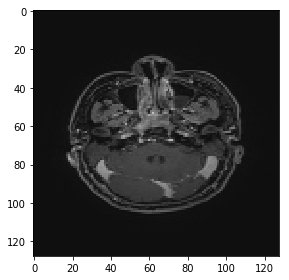

Low image data range; displaying image with stretched contrast.


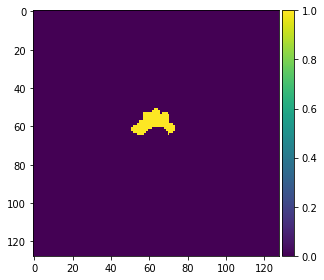

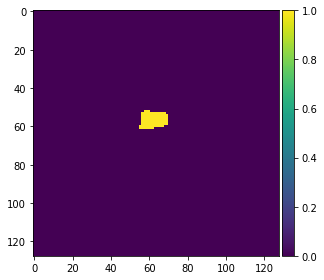

In [24]:
import random
ix = 70
imshow(np.squeeze(train_z[ix]))
plt.show()
imshow(np.squeeze(train_z_m[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [41]:
inputs = Input((IMG_H, IMG_W, 1))
s = Lambda(lambda x: x / 255) (inputs)
local_conv1 = Conv2D(64, (7, 7), activation='relu', padding='same')(s)


In [42]:
conv1.shape

TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(64)])

In [43]:
s.shape

TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(1)])

In [104]:
m1

<tf.Tensor 'lambda_18/Max:0' shape=(?, 1, 64, 64) dtype=float32>

In [105]:
conv1a

<tf.Tensor 'conv2d_231/Relu:0' shape=(?, 64, 64, 64) dtype=float32>

In [106]:
np.save('img3d_train', img_array)
np.save('msk3d_train', msk_array)

In [107]:
img_array.shape

(103, 320, 232)